In [2]:
import pandas as pd
import numpy as np
import talib
from datetime import datetime
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/VENV36/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


<div class="jumbotron">
    <p class="display-1 h1">量化交易策略与模型</p>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

# 交易基础

## 交易操作

<dl class="row text-info">
    <dt class="col-md-2">开仓</dt>
    <dd class="col-md-10">交易者<strong>新</strong>买入或<strong>新</strong>卖出一定数量的交易标的</dd>
</dl>

- 例如，以3500元/吨的价格在期货市场上卖出10手rb2101合约

<dl class="row text-danger">
    <dt class="col-md-2">平仓</dt>
    <dd class="col-md-10">交易者通过<strong>笔数相等</strong>、<strong>方向相反</strong>的交易来对冲原来持有的交易标的的过程</dd>
</dl>

- 以3500元/吨的价格在期货市场上卖出10手rb2101合约，则须在2021年1月之前**买进10手**该月份合约对冲平仓

<dl class="row">
    <dt class="col-md-2">持仓</dt>
    <dd class="col-md-10">开仓之后尚没有平仓的交易标的，是交易者持有交易标的的过程</dd>
</dl>

- 多头头寸：**买入**交易标的后持有的头寸，也被称为***多头***

- 空头头寸：**卖出**交易标的后持有的头寸，也被称为***空头***

## 交易量

<dl class="row text-info">
    <dt class="col-md-2">成交量</dt>
    <dd class="col-md-10">在一个交易时段内买卖某种交易标的的数量</dd>
</dl>

<dl class="row text-danger">
    <dt class="col-md-2">持仓量</dt>
    <dd class="col-md-10">所有投资者持仓的总数，是所有多头与空头数之和</dd>
</dl>

## 价格

### 形态描述类价格

- 开盘价：某一交易标的在某一时间段内**第一笔**成交的价格
- 收盘价：某一交易标的在某一时间段内**最后一笔**成交的价格
- 最高价：某一交易标的在某一时间段内成交的**最高**价格
- 最低价：某一交易标的在某一时间段内成交的**最低**价格

#### 时间长度

- 不同的时间长度对应着不同长度的趋势
    - 例如，1分钟、5分钟、15分钟、1小时、1天、1周、1月、半年、1年等

<center><img src="./img/tradingBasics/timescale.jpg" width=100%></center>

#### K线图(candlestick)

- 选取一个时间长度，然后用该时间长度内的**开盘价、收盘价、最高价、最低价**构成的图形

<center><img src="./img/tradingBasics/candlestick.png" width=70%></center>

##### 获取数据

```python
pip install pandas-datareader
```

```python
import pandas_datareader.data as web
web.DataReader(symbols=None,start=None,end=None,freq='d')
```
- `symbols`：标的物代码，字符串
- `start`：起始日期
- `end`：结束日期
- `freq`：频率，字符串，d, w, m ,q, y 对应日、周、月、季度、年
- 返回`dataframe`格式数据

- 国内股票代码
    - 上证股票代码+'.SS'
    - 深证股票代码+'.SZ'

- 国内股票代码汇总
    - [https://s.askci.com/stock/a/](https://s.askci.com/stock/a/)

In [7]:
# 中国石化
stockPrice = web.DataReader('600028.SS','yahoo',start='2019-1-1',end='2020-11-13')
stockPrice.tail()
stockPrice.shape

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-09,4.04,3.98,3.99,4.01,118274467.0,4.01
2020-11-10,4.14,4.03,4.10,4.04,275912937.0,4.04
2020-11-11,4.13,4.05,4.05,4.12,210512178.0,4.12
2020-11-12,4.12,4.04,4.12,4.06,117668522.0,4.06
2020-11-13,4.06,4.00,4.05,4.02,100156431.0,4.02


(451, 6)

### 结算类价格

<dl class="row">
    <dt class="col-md-2">结算价</dt>
    <dd class="col-md-10">某一期货合约当天的成交价格按照<strong>成交量</strong>的<strong>加权平均</strong>。</dd>
</dl>

- 用来计算保证金账户每天盈亏的价格

### 交易类价格

- Ask：卖价
- Bid：买价

<div align="center">
    <img src="./img/tradingBasics/askbid.png" width=200>
</div>

## 交易指令

- 在委托单上注明：投资者名称、投资者编码、投资者产品名称、合约到期月份、开仓或平仓的数量、买卖价格、执行方式、下单时间、投资者签名

### 市价委托单

- 投资者在提交委托单时只规定数量而不规定价格，经纪商在接到该市价委托单后应以最快的速度，并尽可能以当时市场上最好的价格执行该委托单

- 市价**买进**委托单：以当时市场上**最低**的卖价成交
- 市价**卖出**委托单：以当时市场上**最高**的买价成交

- 特点：能够确保成交，单不能保证成交价格

### 限价委托单

- 下单时不仅规定数量，而且规定价格

> 例如，卖出限价为3500元/吨的rb2005螺纹钢10手

- 限价买进委托单：买入成交价应**不高于**指定的限价
- 限价卖出委托单：卖出成交价应**不低于**指定的限价

- 特点：不能确保成交，但是一旦成交能够保证成交价格

### 止损委托单

- 在委托单中设置一个触发价格，当市场价格上升或者下降到该触发价格的时候，止损委托单被激活，转化成市价委托单

- 多头：当市场价格等于或低于指定的止损价格，则执行市价卖出委托单
- 空头：当市场价格等于或高于指定的止损价格，则执行市价买进委托单

# 量化交易策略的组成

<dl class="row text-danger">
    <dt class="col-md-4">交易策略</dt>
    <dd class="col-md-8">交易策略是交易员进行交易时遵循的交易规则</dd>
</dl>

<center><img src="./img/strategy/strategyComp.png" width=100%></center>

## 交易标的

<dl class="row">
    <dt class="col-lg-4">交易标的</dt>
    <dd class="col-lg-8">应当买卖哪些产品</dd>
</dl>

- 只交易少数几个产品?
- 交易全部产品？

<center><img src="./img/strategy/rbContracts.png"  width=100%></center>

- 对于每个品种，最好交易**主力**合约

<center><img src="./img/strategy/majorContracts.png" width=100% /></center>

- 在所有主力合约中，最好选择**成交量**最大的

##### 如何选择交易标的？

- 选择交易标的的原则
> 选择交易**活跃**（成交量大）的品种合约

- 设定投资组合
    - 总有某个市场或某些产品出现趋势
    - 有些交易不明朗的市场或产品可以先观望
    - 当一些突发事件造成市场波动时，可以对冲风险

## 头寸规模

<dl class="row">
    <dt class="col-md-4">头寸规模</dt>
    <dd class="col-md-8">应当持有的交易标的的数量</dd>
</dl>

### 决定头寸规模的因素

- 可用资金量
    + **全仓**：用全部可用资金购入交易标的
    + **半仓**：用一半资金购入交易标的

- 交易标的的价格

- 市场的波动幅度
    - 波动**强**的市场，头寸规模适当**减小**
    - 波动**弱**的市场，头寸规模适当**增大**

## 入场信号

<dl class="row">
    <dt class="col-md-4">入场信号</dt>
    <dd class="col-md-8">决定何时开始建仓（加仓）的信号</dd>
</dl>

### 信号的含义

- 趋势交易策略：价格形成**突破**

- 统计套利策略：价格差出现**异常**

### 入场信号包含两种情形

- 初次建立仓位
    - 趋势交易策略：技术分析指标
    - 统计套利策略：价格差超过稳定阈值

- 加仓
    - 盈利加仓？亏损加仓？

- 盈利加仓

<center><img src="./img/strategy/winAdd.png" width=100% /></center>

- 亏损加仓

<center><img src="./img/strategy/lossAdd.png" width=100%/></center>

- 程序化交易的入市信号是由交易策略产生的

自动运行的系统产生入市信号，这些信号说明了进入市场买卖的明确的价位和市场条件。

## 离场信号

<dl class="row">
    <dt class="col-md-4">离场信号</dt>
    <dd class="col-md-8">决定何时平调持有的头寸</dd>
</dl>

- 离场信号包含
    - 止盈
    - 止损

### 止盈

> 决定何时平掉持有的盈利头寸

- 是否有必要止盈？

#### 止盈时机的选择

- 过早止盈：不能赚满整个趋势

<center><img src="./img/strategy/earlyWinExit.png" width=100% /></center>

- 过晚止盈：不能保住已经赚取的利润

<center><img src="./img/strategy/lateWinExit.png" width=100% /></center>

### 止损

> 决定何时平掉持有的亏损头寸

- 止损是在建立头寸之前，**预先**确定退出的价格位置

- 如果市场的波动触及止损价位，必须**每一次都毫无例外**退出

<center><img src="./img/strategy/stopLoss.png" width=100%></center>

长期来看，不会止住亏损的交易员不会取得成功。关于止亏，最重要的是在
你建立头寸之前预先设定退出的点位。

## “海龟”交易策略

### 背景

> 伟大的交易员是天生造就还是后天培养的?


<center> <img src="./img/strategy/richard_dennis.jpg" width=40%> </center>

Richard Dennis是一个成功的交易员，他在1980年左右已经将他不到5000$的初始投资变成了1亿。
他的合作伙伴William Eckhardt认为他的成功来自于他作为一个交易员的天分。
但是Dennis不这样认为，他认为他的交易是建立在一套交易法则基础上的，任何人掌握了这套交易法则，将能够复制他的成功。
最后他们决定做个实验来证实到底谁是对的。

他们在《巴伦氏》、《华尔街期刊》和《纽约时报》上刊登了大幅广告，招聘交易学员。
因为Richard或许是当时世界上最著名的交易员，所以有1000 多位申请人前来投奔他。他会见了其中的 80 位。
这一群人精选出 13 个人。1983 年 12 月底，学员们
被邀请到芝加哥进行两周的培训，到 1984 年 1 月初，学员们开始用小帐户进行交
易。到了 2 月初，Richard给其中的大多数人提供了 50 万$\sim$ 200 万美元的资金帐户。


- 从1000名报名者中挑选出13人
- 1983 年 12 月底，学员们被邀请到芝加哥进行两周的培训
- 1984 年初，Richard给其中的大多数人提供了 50 万$\sim$ 200 万美元的资金帐用于交易
- 学员们被称为“海龟”
- 在随后的四年中海龟们取得了年均复利80%的收益


学员们被称为“海龟”，因为Dennis相信他可以迅速的培养出交易员，就像新加坡的海龟培养员能迅速高效的培养出海龟一样。
Dennis教授这些海龟们依靠科学的方法进行交易，以减少交易对心理的冲击，因为心理的脆弱最可能使得人们犯错误从而损失惨重。
海龟成为交易史上最著名的实验，因为在随后的四年中海龟们取得了年均复利80%的收益。

> Denniss证明了交易可以被传授。他证明了用一套简单的法则，他可以仅有很少或根本没有交易经验的人成为优秀的交易员。

### 交易产品

- 芝加哥期货交易所（CBOT）    
    - 30 年期美国长期国债（Treasury Bond）、10 年期美国中期国库券（Treasury Note）
- 纽约咖啡可可与原糖交易所（NYCSC）    
    - 咖啡、可可、原糖、棉花
- 芝加哥商品交易所（CME）    
    - 瑞士法郎、德国马克、英镑、法国法郎、日圆、加拿大元、标准普尔500股票指数、欧洲美元、天美国短期国库券（Treasury Bill）  
- 纽约商品期货交易所（COMEX）    
    - 黄金、白银、铜  
- 纽约商业期货交易所（NYMEX）    
    - 原油、燃油、无铅汽油 

### 头寸规模

#### 单位建仓量

- 计算当日实际波动范围（TR, True Range）：  
  $$ \text{TR} = \max\{\text{H}-\text{L}, \lvert\text{H}-\text{PDC}\rvert, \lvert\text{PDC}-\text{L}\rvert\} $$
  其中：  H——当日最高价，L——当日最低价，PDC——前个交易日的收盘价

<center><img src="./img/strategy/atr1.png" width=80%></center>

- 计算 ATR (TR的20日平均）：  
  $$ \text{ATR}_t = (19\times\text{ATR}_{t-1} + \text{TR})/20  $$ 
  其中：TR——当日的实际波动范围 

<center><img src="./img/strategy/atr.png" width=100%></center>

- 计算单位建仓量
   $$ \text{1个建仓单位} = \frac{\text{帐户资金金额的}1\%}{\text{ATR}\times\text{每点价值量（交易单位）}} $$ 

#### 最大头寸限制

<center>

级别|类型|最大单位
---|---|---   
1|单一市场|4个单位
2|高度相关市场|6个单位
3|低度相关市场|10个单位  
4|单向交易（多头或空头）|12个单位
    
</center>

### 入市时机

> 以唐奇安通道(Donchian’s channel)突破作为入市时机

<dl class="row"> 
    <dt class="col-md-4">唐奇安通道</dt>
    <dd class="col-md-8">特定天数内的最高价和最低价组成的通道</dd>
</dl>

<center><img src="./img/strategy/donchian.png" width=100%></center>

- 上线=$\max（前T个交易日的最高价）$
- 下线=$\min（前T个交易日的最低价）$
- 中线=（上线+下线）/2

- $T=20$，每个交易日结束之后更新当天的数据

##### 初始建仓

- 如果当前价格<font color="red"><strong>涨过</strong></font>了前20日的<font color="red"><strong>最高价</strong></font>，建立1个单位**多头**寸
- 如果当前价格<font color="green"><strong>跌过</strong></font>了前20日的<font color="green"><strong>最低价</strong></font>，建立1个单位**空头**寸。

> 在日间**突破发生时**进行交易，而不会等到每日收盘或次日开盘

##### 加仓 

- 在上一次实际成交价格的基础上，以$\frac{1}{2}$ATR的间隔增加头寸

- 假设rb的建仓价格为3800，ATR=46
    - 第1个单位头寸：$3800$
    - 第2个单位头寸：$3800+1/2*46=3823$
    - 第3个单位头寸：$3823+1/2*46=3846$
    - 第4个单位头寸：$3846+1/2*46=3869$

### 离场信号

#### 止损

> 以头寸风险为基础设置止损，任何一笔交易都不能出现 2%以上的风险

- 因为1个ATR对应的价格波动代表1%的账户权益，因此2%的风险对应价格相对于建仓方向反向波动**2个ATR**

- 例如，在3800元/吨建立第一个单位的rb头寸，则止损价位为：
    - $3800-2\times 46=3708$

> 海龟系统的止损能够适应市场的波动性

- 加仓之后，前面仓位的止损价格增加$\frac{1}{2}$ATR，导致所有仓位的止损价格距离最近加仓价格的距离为2ATR

<center><img src="./img/strategy/stopLevel.png" width=80%></center>

#### 止盈

- 如果持有多头头寸，则当价格跌破 10 日最低价的时候离场
- 如果持有空头头寸，则当价格涨过10 日最高价的时候离场

海龟交易系统是一个完整的交易系统，它包括了交易的各个方面，实际上没
有给交易员留下一点主观想象决策的余地。
海龟策略从本质上讲是一个趋势跟随模型，通过唐安奇通道等突破方法确定入场和离场信号。海龟交易法则与其说是策略，不如说是一套系统，它不仅决定买卖什么、买卖多少、什么时候买卖、什么时候止损，还决定具体怎么买卖。

# 量化交易系统

- 量化交易系统由**量化交易模型**驱动

<center><img src="./img/models/tradingSystem.png" width=100%></center>

- 数据模型
    - 数据的获取、存储、处理等

- Alpha模型
    - 决定入场、离场的时机

- 风险控制模型
    - 控制损失

- 交易成本模型
    - 估计交易成本（交易手续费等）与收益

- 投资组合模型
    - 决定希望持有的品种与头寸规模

- 交易执行模型
    - 有效率、低成本的执行买卖交易指令

# 数据模型

> 数据是量化交易模型的基础

## 数据类型

<center><img src="./img/models/dataType.png" width=100%></center>

## 数据的获取

### 从第三方终端获取数据

- 典型平台
    - Wind数据库
    - [TuShare https://tushare.pro/](https://tushare.pro/)
        - 注册获得token
    - [JointQuant https://www.joinquant.com/](https://www.joinquant.com/)
        - 注册获得一年的免费使用权限

- 优缺点：
    - 优点：数据经过加工处理
    - 缺点：速度慢

### 从交易所获取数据

- 典型接口
    - 交易接口CTP（Comprehensive Transaction Platform）[http://www.sfit.com.cn/](http://www.sfit.com.cn/)
    - 基于CTP的`Python`量化框架：[vn.py https://www.vnpy.com/](https://www.vnpy.com/)

- 优缺点：
    - 优点：速度快、原始数据
    - 缺点：需要自己学习接口使用，清理数据

## 数据处理

- 噪声数据，即无意义的或错误的数据，既浪费存储空间，更严重的是导致错误的分析结果

### 缺失数据

#### 检查是否含有缺失值

- 在Python中用`NaN`（Not a Number）表示缺失值

In [8]:
rbDat = pd.read_csv('./data/models/rbNan.csv',index_col=0)
rbDat.head()
rbDat.shape

,Close,High,Low
ActionDay,,,
20160104,1775.0,1806.0,1773.0
20160105,1779.0,NaN,1761.0
20160106,1783.0,1786.0,1766.0
20160107,NaN,1786.0,1747.0
20160108,1752.0,1775.0,NaN


(1150, 3)

- 对于`pandas`的`DataFrame`结构，检验是否含有缺失值的方法
    - `DataFrame.isna()`

In [14]:
rbDat.isna()

,Close,High,Low
ActionDay,,,
20160104,False,False,False
20160105,False,True,False
20160106,False,False,False
20160107,True,False,False
20160108,False,False,True
...,...,...,...
20200826,False,False,False
20200827,False,False,False
20200828,False,False,False


- 显示含有缺失值的行

In [16]:
rbDat.loc[rbDat.isna().sum(axis=1)>0]

,Close,High,Low
ActionDay,,,
20160105,1779.0,NaN,1761.0
20160107,NaN,1786.0,1747.0
20160108,1752.0,1775.0,NaN
20160513,NaN,2064.0,2001.0
20161013,2354.0,NaN,2331.0
20170314,3597.0,3624.0,NaN
20170919,NaN,NaN,NaN
20180702,NaN,3807.0,3737.0
20190920,3392.0,NaN,3378.0


#### 删除缺失值

- `DataFrame`删除缺失值的方法
    - `DataFrame.dropna(axis=0, how='any', inplace=False)`
        - `axis`：取值为0，删除含有缺失值的行；取值为1，删除含有缺失值的列
        - `how`：取值为`any`，只要含有缺失值，就删除相应的行或列；取值为`all`，只有行或列的所有元素都是缺失值，才会删除该行或列
        - `inplace`：是否更新原始的`DataFrame`

In [203]:
rbRem = rbDat.dropna(how='all')
rbRem.shape

(1149, 3)

# Alpha模型

- Alpha意味着获取**超额收益**

<center><img src="./img/models/alphaModels.png" width=100%></center>

## 趋势追踪模型

- 在趋势初期入场，在趋势末期离场

- 技术指标是识别趋势的重要方法

### 技术指标的概念

> 基于价格、成交量、持仓量等的历史数据而构建的启发式或数学计算指标


- [https://www.visualcapitalist.com/12-types-technical-indicators-stocks/](https://www.visualcapitalist.com/12-types-technical-indicators-stocks/)
- [https://www.theforexchronicles.com/the-4-different-types-of-technical-indicators-that-you-can-use/](https://www.theforexchronicles.com/the-4-different-types-of-technical-indicators-that-you-can-use/)

### 技术指标的分类

- 根据技术指标的具体内容
    - 趋势指标
    - 能量指标
    - 波动性指标
    - 交易量指标

#### 趋势指标（trend indicators）

- 通过将标的资产的价格与基准比较（通常是均值），判断趋势的方向与强度
    - 价格超过均值，上升趋势
    - 价格跌破均值，下跌趋势

- 包括
    - 简单移动平均
    - 指数移动平均
    - MACD
    - 。。。

##### 简单移动平均（simple moving average, SMA)

$$SMA_t(n)=\frac{1}{n}\sum_{i=0}^{n-1}p_{t-i}$$

- 其中, $p_t$是$t$时刻的价格，$n$可以取3分钟、5分钟、15分钟，60分钟等。

- TA-Lib金融软件包是目前最常用的技术指标函数库，包括150多个技术指标

- 下载安装包[https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib](https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib)

- 从本地安装TA-Lib，

```python
pip install d:/TA_Lib-0.4.19-cp39-cp39-win_amd64.whl
```
- 使用TA-Lib包的方法，

``` python
import talib
```

In [56]:
hsdf = web.DataReader('600519.SS','yahoo',start='2019-1-1',end='2020-11-16')
hsdf.shape
hsdf.head()

(452, 6)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,612.000000,595.010010,609.979980,598.979980,6228649.0,583.424377
2019-01-03,601.659973,585.799988,599.969971,590.000000,3097735.0,574.677612
2019-01-04,607.669983,582.020020,587.280029,602.000000,3768347.0,586.366028
2019-01-07,610.299988,602.219971,587.280029,605.489990,3475013.0,589.765381
2019-01-08,612.000000,600.280029,605.500000,604.789978,2883813.0,589.083496


In [57]:
rSMA = talib.SMA(hsdf['Close'], timeperiod=30)
rSMA

Date
2019-01-02            NaN
2019-01-03            NaN
2019-01-04            NaN
2019-01-07            NaN
2019-01-08            NaN
                 ...     
2020-11-10    1693.172660
2020-11-11    1695.361328
2020-11-12    1698.188330
2020-11-13    1700.710999
2020-11-16    1703.875667
Length: 452, dtype: float64

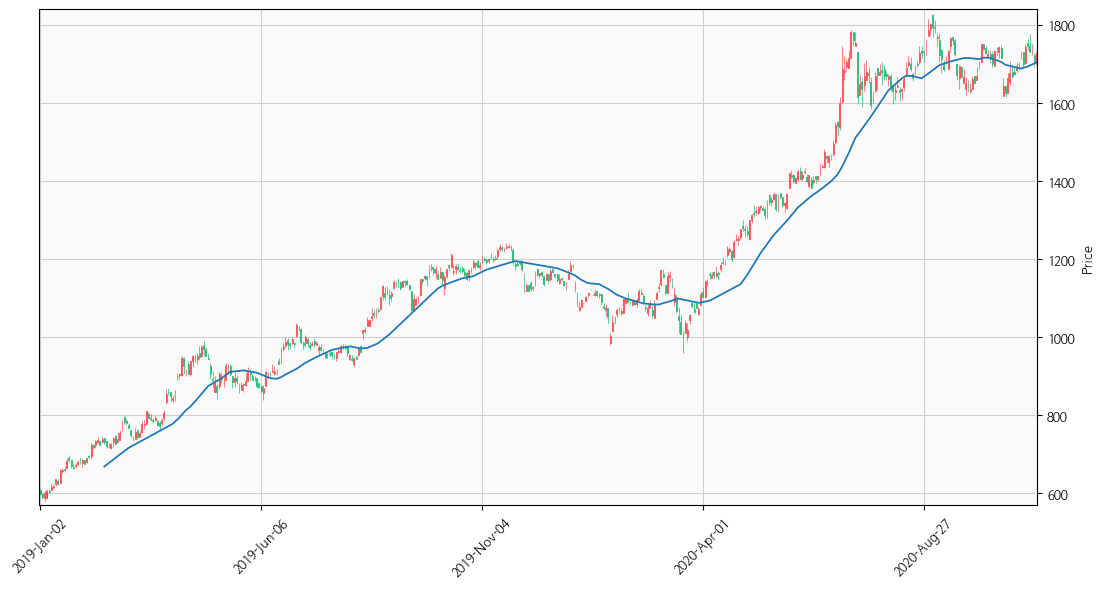

In [58]:
mc = mpf.make_marketcolors(up='#fe3032', down='#00b060', inherit=True)
sty = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=mc,rc={'font.family':'HYQuanTangShiJ'})
smaFig = mpf.make_addplot(rSMA)
mpf.plot(hsdf,type='candle',style=sty,addplot=smaFig,figratio=(12,6),figscale=1,tight_layout=True)

##### 指数移动平均（exponential moving average, EMA）

$$EMA_t(\alpha)=\alpha EMA_{t-1}+(1-\alpha)p_t$$

- 其中，$\alpha\in(0,1)$，$p_t$为$t$时刻价格

In [59]:
rEMA = talib.EMA(hsdf['Close'], timeperiod=30)

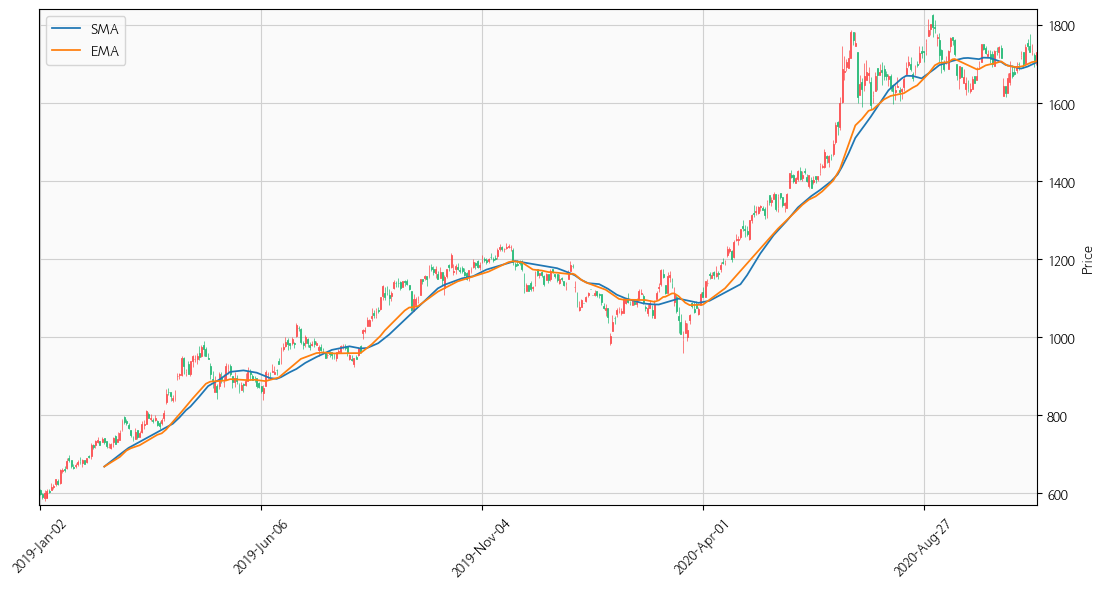

In [60]:
mvFig = [mpf.make_addplot(rSMA),
          mpf.make_addplot(rEMA)]
fig,ax = mpf.plot(hsdf,type='candle',style=sty,addplot=mvFig,figratio=(12,6),figscale=1, returnfig=True,tight_layout=True)
ax[0].legend(['SMA','EMA'],loc='upper left')

##### EMA与SMA比较

- EMA给最新价格和历史价格不同的权重，而SMA同等对待每个价格

- EMA利用所有历史价格信息，只是随着时间推移，历史价格信息的影响在逐渐减少，而SMA只用到了时间窗口内的价格信息

##### MACD（Moving Average Convergence and Divergence)

- MACD称为异同移动平均线，由双指数移动平均线构成。
- 利用收盘价的短期（常用为12日）指数移动平均线与长期（常用为26日）指数移动平均线之间的聚合与分离状况，对买进、卖出时机作出研判。

- **MACD线**： $12\text{-day 价格EMA} - 26\text{-day 价格EMA}$
- **信号线**： $9\text{-day MACD线的EMA}$

- **MACD 柱状图**： $\text{MACD线} - \text{Signal线}$

In [61]:
macd, macdsignal, macdhist = talib.MACD(hsdf['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

/home/VENV36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/VENV36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


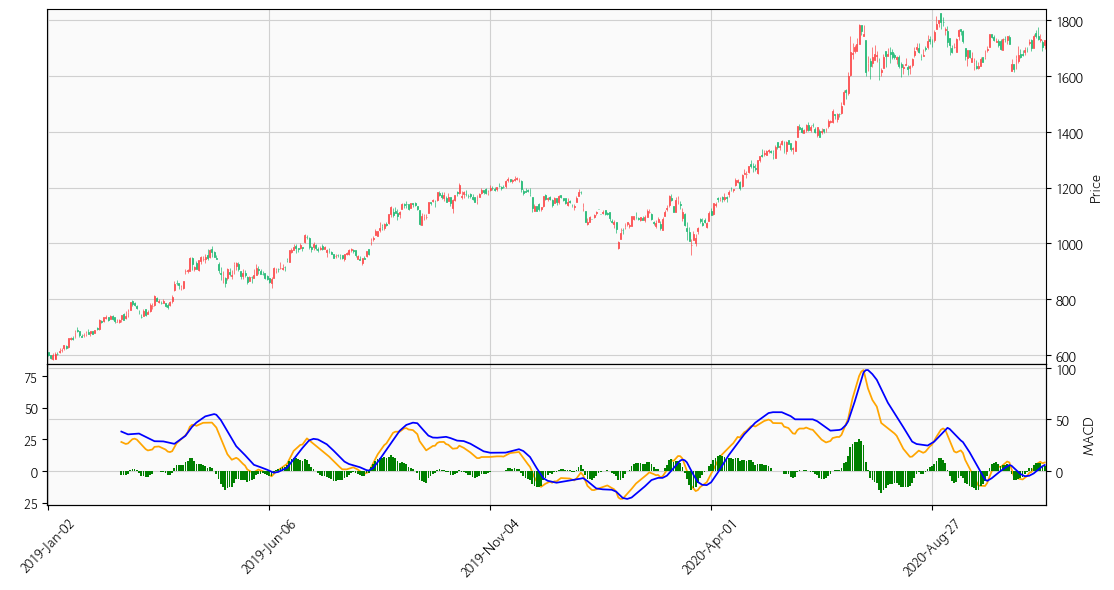

In [62]:
macdFig = [mpf.make_addplot(macd,panel=1,color='orange',ylabel='MACD'),
          mpf.make_addplot(macdsignal,panel=1,color='blue'),
          mpf.make_addplot(macdhist,type='bar',color='green',panel=1)]
mpf.plot(hsdf,type='candle',style=sty,addplot=macdFig,figratio=(12,6),figscale=1,tight_layout=True)

- 当**MACD线**向上穿越**信号线**，做多信号
- 当**MADC线**向下穿越**信号线**，做空信号

#### 能量指标（momentum indicators）

- 通过衡量价格上涨或下跌的变化幅度
- 帮助判别趋势的强度

##### 相对强度指数（relative strength index, RSI）

- 计算一段时间内价格向上波动占价格绝对波动的比例

```python
if close(t) > close(t-1):
    up = close(t)-close(t-1)
    dn = 0
else:
    up = 0
    dn = close(t-1)-close(t)
# close(t)是t时刻的收盘价
```

\begin{align}
  upavg = \frac{upavg\times(t-1)+up}{t} \\
  dnavg = \frac{dnavg\times(t-1)+dn}{t} \\
  RSI = \frac{upavg}{upavg+dnavg}\times100
\end{align}
- 其中，$upavg$是价格上涨幅度的均值，$dnavg$价格下跌幅度的均值

- 波动范围是$[0,100]$

In [63]:
rRSI = talib.RSI(hsdf['Close'], timeperiod=14)

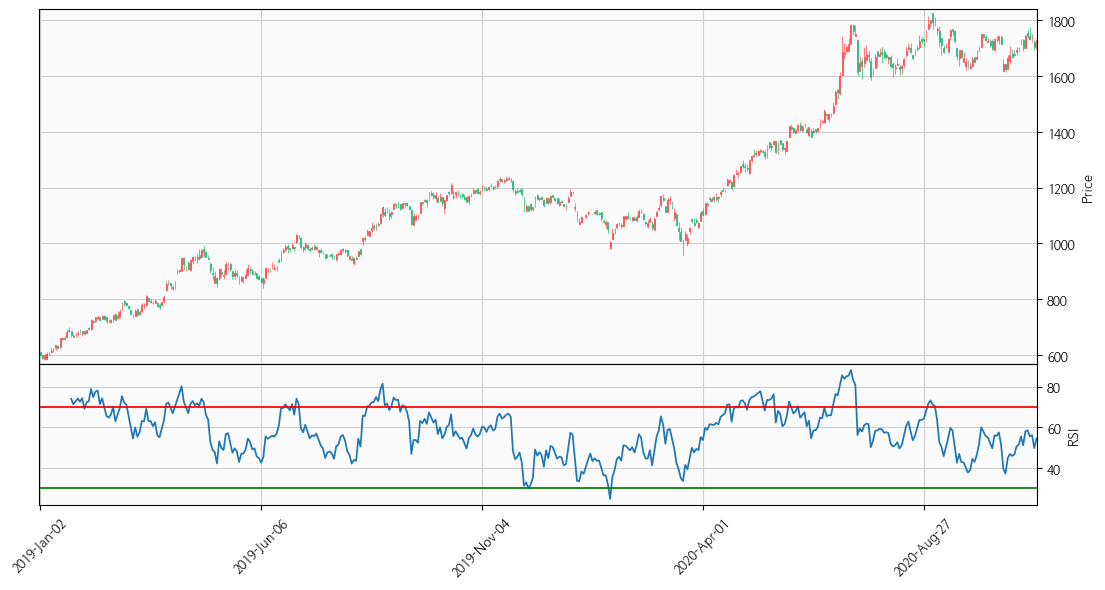

In [64]:
line70 = np.ones(hsdf.shape[0])*70
line30 = np.ones(hsdf.shape[0])*30
rsiFig = [mpf.make_addplot(rRSI,panel=1,ylabel='RSI'),
          mpf.make_addplot(line70,panel=1,color='red',secondary_y=False),
          mpf.make_addplot(line30,panel=1,color='green',secondary_y=False),         
         ]
mpf.plot(hsdf,type='candle',style=sty,addplot=rsiFig,figratio=(12,6),figscale=1,tight_layout=True)

- $\text{RSI}>70$：超买(overbought)，标的的**交易价格**<font color="red">超过</font>其**内在价值**(intrinsic value)或市场价值，意味着价格近期将会调整
- $\text{RSI}<30$：超卖(oversold)，标的**交易价格**<font color="green">低于</font>其**内在价值**或市场价值，意味着价格近期将会调整

- 在上升区间，RSI应当稳定在30以上，并且经常触碰70
- 在下跌区间，RSI应当几乎不超过70，并且经常触碰30

##### 商品通道指数（commodity channel index）

- 用来识别趋势的开始点与结束点

$$
\text{CCI}=\frac{\text{TP}-\text{ATP}}{0.015\times\text{MD}}
$$

- $\text{TP}=\frac{high_n+low_n+close}{3}$：典型价格（typical price）
- $high_n$：$n$个周期内的最高价
- $low_n$：$n$个周期内的最低价
- $\text{ATP}$：典型价格的简单移动平均
- $MD=\frac{\sum_n|\text{TP}-\text{ATP}|}{n}$：典型价格平均离差

In [65]:
rCCI = talib.CCI(hsdf['High'], hsdf['Low'], hsdf['Close'], timeperiod=14)

/home/VENV36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/VENV36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


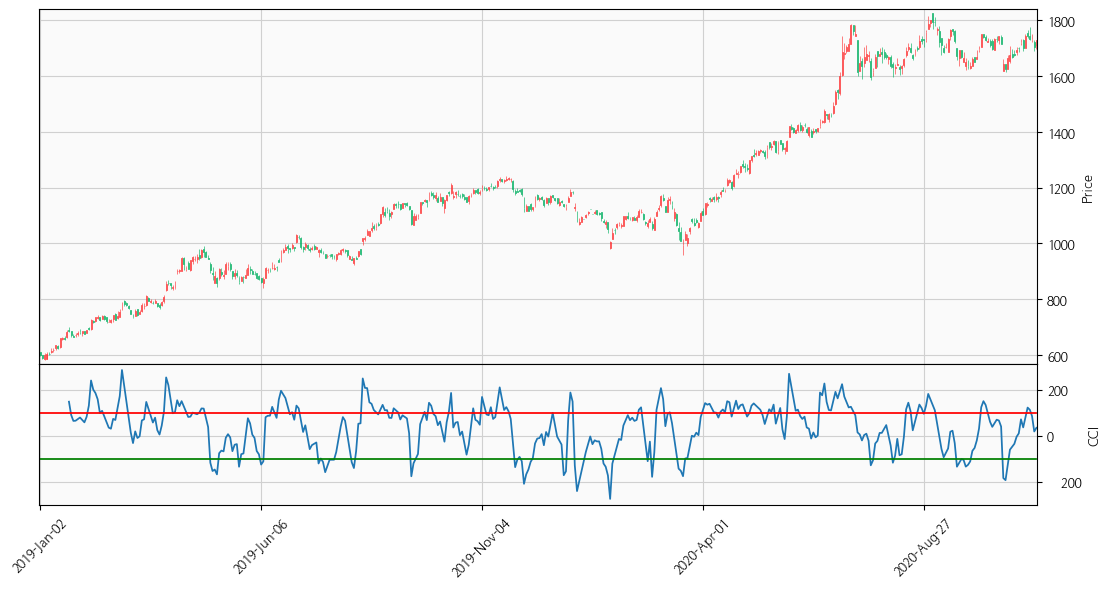

In [66]:
line100 = np.ones(hsdf.shape[0])*100
linen100 = np.ones(hsdf.shape[0])*(-100)
cciFig = [mpf.make_addplot(rCCI,panel=1,ylabel='CCI'),
          mpf.make_addplot(line100,panel=1,color='red',secondary_y=False),
          mpf.make_addplot(linen100,panel=1,color='green',secondary_y=False),         
         ]
mpf.plot(hsdf,type='candle',style=sty,addplot=cciFig,figratio=(12,6),figscale=1,tight_layout=True)

- 当CCI由负值超过100，意味着出现上升趋势
- 当CCI由正值跌破-100，意味着出现下跌趋势

#### 波动性指标（volatility indicators）

- 衡量价格波动程度

##### 平均真实变动范围（average true range）

In [67]:
rATR = talib.ATR(hsdf['High'], hsdf['Low'], hsdf['Close'], timeperiod=14)
rATR

Date
2019-01-02          NaN
2019-01-03          NaN
2019-01-04          NaN
2019-01-07          NaN
2019-01-08          NaN
                ...    
2020-11-10    37.223778
2020-11-11    37.886365
2020-11-12    37.160909
2020-11-13    37.634419
2020-11-16    37.288391
Length: 452, dtype: float64

##### 布林带（Bollinger Bands）

> 价格在移动均线上下附近增加了波动性的带状图形。其中波动性的计算是基于不断变化的标准差

- 中线（Middle Band） = 20天移动平均
- 上线（Upper Band） = 中线 + 2倍20天价格标准差
- 下线（Lower Band） = 中线 - 2倍20天价格标准差

In [68]:
upperband, middleband, lowerband = talib.BBANDS(hsdf['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

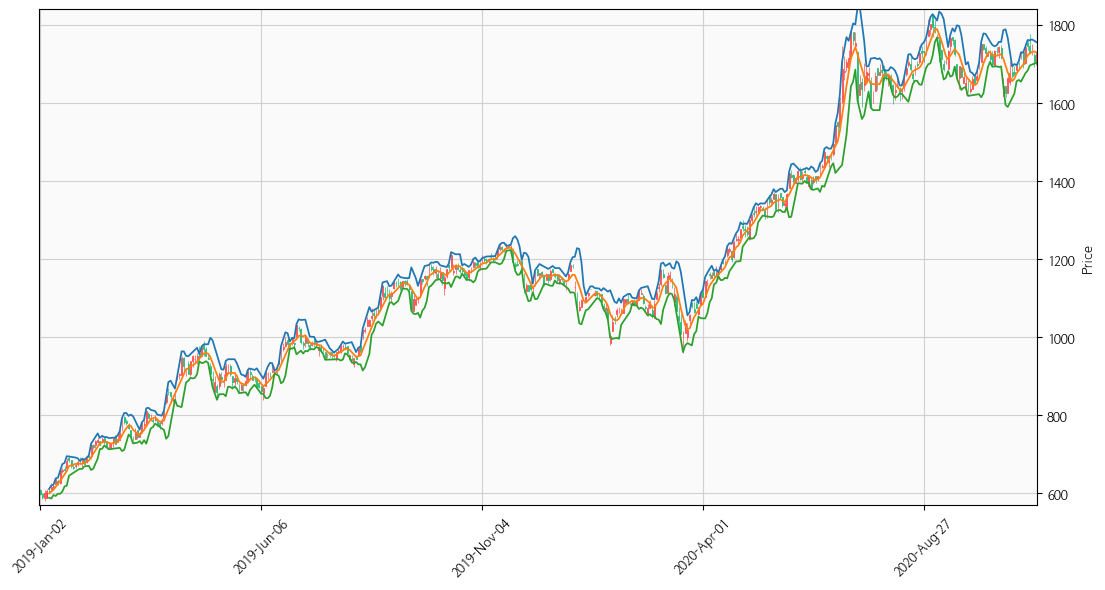

In [69]:
bbandsFig = [mpf.make_addplot(upperband),
          mpf.make_addplot(middleband),
          mpf.make_addplot(lowerband),         
         ]
mpf.plot(hsdf,type='candle',style=sty,addplot=bbandsFig,figratio=(12,6),figscale=1,tight_layout=True)

- 如果价格波动性增加，布林带就会变宽；相反，价格波动性降低，布林带就会收缩

- 在价格上升阶段，价格会在**中线**和**上线**之间波动
    - 一旦价格跌破中线，有可能开始下跌
    - 下线即为下跌的目标价位

- 在价格下跌阶段，价格会在**中线**和**下线**之间波动
    - 一旦价格突破中线，有可能开始上涨
    - 上线即为上涨的目标价位

#### 交易量指标（volume indicators）

- 利用交易量衡量价格趋势的强度，以及对价格方向的确认

##### On-balance volume (OBV)

- 做多与做空成交量的累计和

```python
if close(t)>close(t-1):
    OBV(t) = OBV(t-1) + volume
elif close(t)<close(t-1):
    OBV(t) = OBV(t-1) - volume
else:
    OBV(t) = OBV(t-1)
```

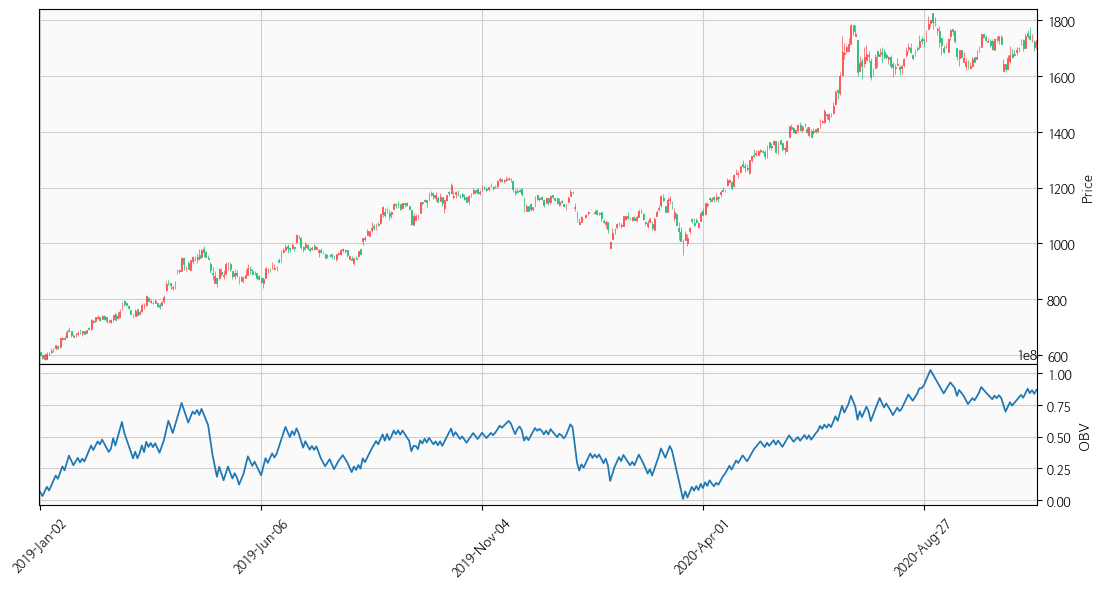

In [70]:
rOBV = talib.OBV(hsdf['Close'], hsdf['Volume'])
obvFig = mpf.make_addplot(rOBV,panel=1,ylabel='OBV')
mpf.plot(hsdf,type='candle',style=sty,addplot=obvFig,figratio=(12,6),figscale=1,tight_layout=True)

- OBV显示出一系列上升的尖峰，表明较强的上涨趋势
- OBV显示出一系列下跌的谷底，表明较强的下跌趋势

##### Chaikin oscillator

- Accumulation/Distribution Line （ADL）：类似于OBV，只是累加或减去的是$\text{当期成交量}\times \text{收盘价位置指数}$
- 收盘价位置指数（close location value, CLV)的计算方法为

$$\text{CLV} = \frac{(\text{close}-\text{low})-(\text{high}-\text{close})}{\text{high}-\text{low}}$$
- Chaikin oscillator：ADL的$n$周期移动平均$-$ADL的$m$周期移动平均

/home/VENV36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/VENV36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


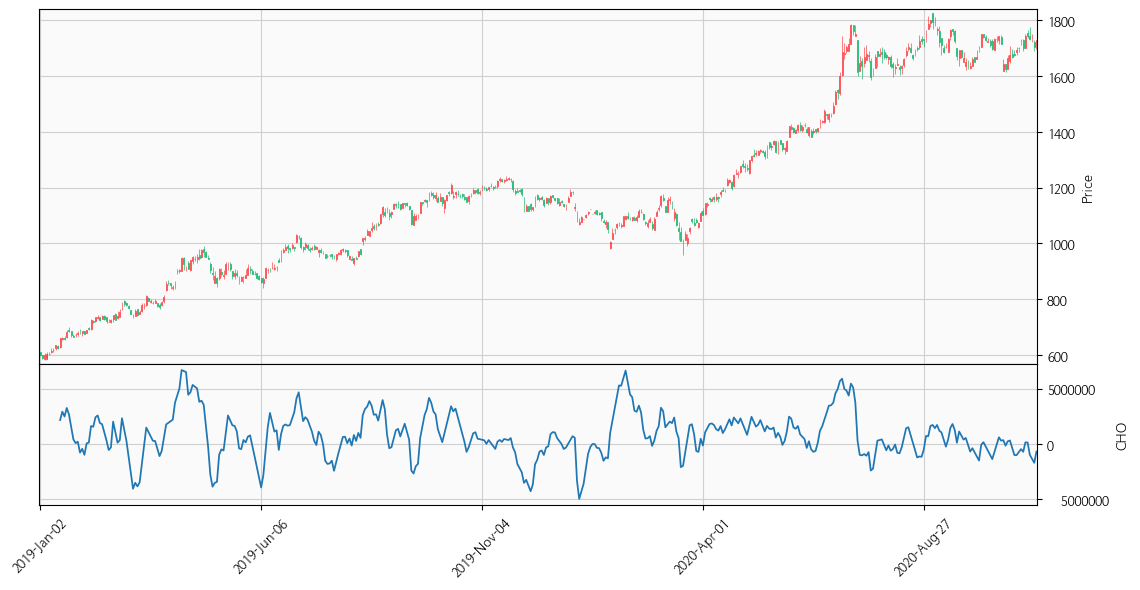

In [71]:
rCHO = talib.ADOSC(hsdf['High'], hsdf['Low'], hsdf['Close'], hsdf['Volume'], fastperiod=3, slowperiod=10)
choFig = mpf.make_addplot(rCHO,panel=1,ylabel='CHO')
mpf.plot(hsdf,type='candle',style=sty,addplot=choFig,figratio=(12,6),figscale=1,tight_layout=True)

- 当Chaikin oscillator为正值，表明买方压力积聚，意味着上涨趋势
- 当Chaikin oscillator为负值，表明卖方压力积聚，意味着下跌趋势

## 均值回归模型

<div class="row">
    <div class="col-md-6">
        <img src="./img/models/trend.jpg" width=90%>
    </div>
    <div class="col-md-6">
        <img src="./img/models/arbitrage.jpg" width=90%>
    </div>
</div>

- 理论基础
    > 标的资产的价格总是围绕着其内在价值波动，一旦趋势结束，价格必然出现反方向运动，回到价值附近

- 常用的实现方式
    > 配对交易（套利）

- 原因
    - 单一资产的内在价值较难确定
    - 对于两个高度相关资产，一种资产的价格就可以近似成为另一种资产的内在价值

### 协整分析

平稳（时间）序列是包括均值、方差和自相关等在内的统计特性不随时间发生变化的时间序列。
非平稳序列数据可能包含趋势（trend）、季节性（seasonality)，或者随机游走（random walk）。
随机游走是一种随机过程，每个时刻的数据只跟前一个数据和各自的随机误差有关。
几乎所有的原始价格时间序列数据都是非平稳的。

<dl class="row">
    <dt class="col-md-4">协整(cointegration)</dt>
    <dd class="col-md-8">两个时间序列各自都是<strong>非平稳过程</strong>，但是它们的线性组合是<strong>平稳过程</strong></dd>
</dl>

<dl class="row">
    <dt class="col-md-4">平稳过程</dt>
    <dd class="col-md-8">统计特性在时间平移下不变的随机过程</dd>
</dl>

- 假设有一个时间序列$\{X_t\}$，则该序列是平稳过程需要满足下面的条件：


1. $E[X_t] = \mu$
2. $Var[X_t] = \sigma^2$
3. $Cov(X_t, X_{t+k}) = r(k)$

<center><img src="./img/strategy/stationary.png" width=60%></center>

##### 检验协整关系

- 设有两个时间序列$\{X_t\}$ 和 $\{Y_t\}$,


1. 利用最小二乘（OLS）法估计$X_t$ 和 $Y_t$ 的长期均衡关系式$Y_t=\alpha_0+\alpha_1X_t+e_t$，并计算误差：
\begin{align}
  \hat{Y}_t &= \hat{\alpha}_0 + \hat{\alpha}_1 X_t \\
  \hat{e}_t &= Y_t - \hat{Y}_t \\
\end{align}

2. 检验残差序列$\{\hat{e}_t\}$的平稳性。可用ADF检验，如果通过检验，说明$X_t$ 和 $Y_t$具有协整关系。

### `Python`实现

```python
pip install statsmodels
import statsmodels.api as sm
coint_t, pvalue, crit_value = sm.tsa.stattools.coint(y0, y1)
```
- `y0`与`y1`：需要检验的两个价格序列
- `coint_t`：对回归残差单位根检验的`t`统计量
- `pvalue`：单位根检验的显著性水平
- `crit_value`：单位根检验分别在1%、5%、10%上的临界值

In [258]:
retAapl = web.DataReader('AAPL',start='2018-1-1',end='2020-9-23',data_source='stooq')
retAapl.head()
retGoog = web.DataReader('GOOG',start='2018-1-1',end='2020-9-23',data_source='stooq')
retGoog.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-09-22,112.68,112.86,109.16,111.81,183055373
2020-09-21,104.54,110.19,103.10,110.08,195713815
2020-09-18,110.40,110.88,106.09,106.84,287104882
2020-09-17,109.72,112.20,108.71,110.34,178010968
2020-09-16,115.23,116.00,112.04,112.13,155026675


,Open,High,Low,Close,Volume
Date,,,,,
2020-09-22,1450.09,1469.5200,1434.5300,1465.46,1583201
2020-09-21,1440.06,1448.3600,1406.5500,1431.16,2888827
2020-09-18,1498.01,1503.0032,1437.1300,1459.99,3103882
2020-09-17,1496.00,1508.2984,1470.0001,1495.53,1879751
2020-09-16,1555.54,1562.0000,1519.8200,1520.90,1312299


In [259]:
retAapl.sort_index(inplace=True)
retAapl.head()
retGoog.sort_index(inplace=True)
retGoog.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,41.008,41.522,40.790,41.512,105892200
2018-01-03,41.578,42.062,41.438,41.505,122271476
2018-01-04,41.580,41.808,41.468,41.702,92736404
2018-01-05,41.800,42.265,41.708,42.172,97913124
2018-01-08,42.018,42.322,41.918,42.028,85190420


,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,1048.34,1066.94,1045.23,1064.90,1236401
2018-01-03,1064.31,1086.29,1063.21,1082.48,1429883
2018-01-04,1088.00,1093.57,1084.00,1086.40,1003740
2018-01-05,1094.00,1104.25,1092.00,1102.23,1278921
2018-01-08,1102.23,1111.27,1101.62,1106.94,1046769


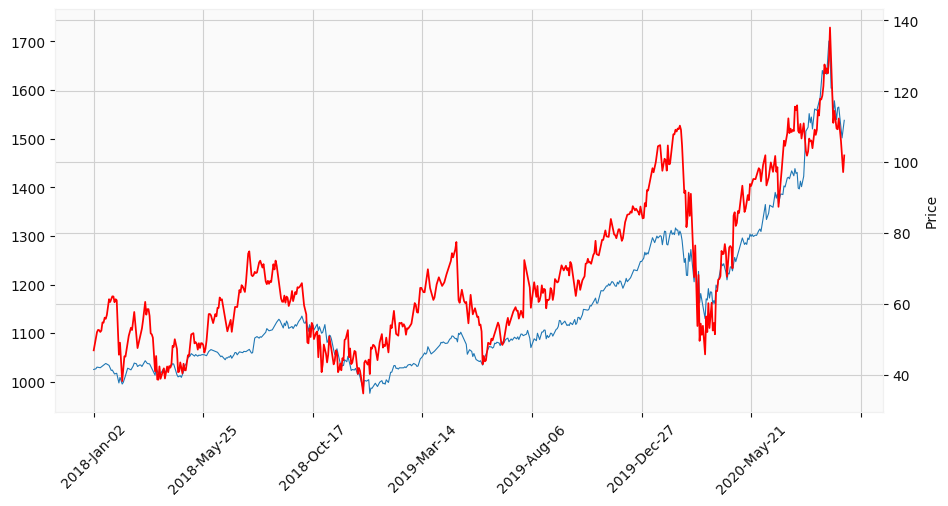

In [269]:
subfig = mpf.make_addplot(retGoog['Close'],color='red')
mpf.plot(retAapl,type='line',style='yahoo',addplot=subfig,figratio=(12,6),figscale=1)

In [270]:
res = sm.tsa.stattools.coint(np.log(retAapl['Close']), np.log(retGoog['Close']))
print(f't_val {res[0]}, p_val {res[1]}, crit_val {res[2]}')

t_val -3.465079997579618, p_val 0.03561907897134225, crit_val [-3.91249963 -3.3450644  -3.05064733]


- 在95%的置信水平上拒绝原假设，可以认为两个价格序列之间具有协整关系

## 多因子模型

<dl class="row">
    <dt class="col-md-4">多因子模型</dt>
    <dd class="col-md-8">利用<strong>多个</strong>对资产价格（例如，股票价格、期货价格等）走势有显著且有效的因子建立的量化模型，以解释和预测均衡资产价格</dd>
</dl>

<dl class="row">
    <dt class="col-md-4">因子（factor）</dt>
    <dd class="col-md-8">一个现象产生后，对于下周期收益率有影响</dd>
</dl>

### CAPM模型

\begin{equation}
  E(r_i)=r_f+\beta_i\left(E(r_m)-r_f\right)
\end{equation}

- $\beta_i$：风险系数
- $E(r_i)$：第$i$个资产的期望价格（收益）
- $r_f$：无风险收益
- $E(r_m)$：市场组合的期望收益

- 假设
    1. 所有投资者都希望获得最大收益
    2. 所有投资者在投资期内的预期收益服从**相同**的概率分布
    3. 所有投资者对风险都具有**相同**的偏好和估计
    4. 所有投资者都使用风险化收益模型进行投资
    5. 资者都具有**风险相同的情况下偏好高收益**，**收益相同的情况下偏好低风险**的投资风格

> 假设过于严格，尤其2-5与实际情况不符

### APT模型

- APT(Arbitrage Pricing Theory)套利定价理论

\begin{equation}
  E(r_i)=r_f+\beta_{i1}\times RP_1+\beta_{i2}\times RP_2+\cdots+\beta_{in}\times RP_n
\end{equation}

- $\beta_{ij}$：资产$i$对第$j$个因素的敏感度
- $RP_j$：影响资产价格（收益）的第$j$个因子

- 相对于CAPM模型，APT模型
    - 不需要假设所有投资者对市场的预期一致
    - 没有假设市场是完全有效的，存在价格扭曲

- APT模型的局限
    - 不知道有多少个因子
    - 不知道哪些因子能够对资产价格（收益）产生显著影响

### Fama-French三因子模型

\begin{equation}
  E(r_i)=r_f+\beta_1\left(E(r_m)-r_f\right)+\beta_2E(SMB)+\beta_3E(HML)
\end{equation}

#### $SMB$

- Small Minus Big，市值因子

- 小市值（market captilization）公司的股票回报会超过大市值公司的股票回报

#### $HML$

- High Minus Low，账面市值比

- 高账面市值比（价值股）公司的股票回报会超过低账面市值比（成长股）公司的股票回报

### 因子的分类

#### 股票交易相关因子

##### 价值因子

- 对应价值型投资，买入便宜的资产长期持有以获得超额收益

- 典型指标
    - 盈利收益率，$E/P$
    - 市净率

##### 成长因子

- 对应成长型投资，依据资产的历史增长水平对未来预测

- 典型指标
    - 净资产收益率（ROE）
    - 总资产收益率（ROA）
    - 主营收入增长率
    - 市盈率相对盈利增长比例，$PEG=\frac{PE}{年盈利增长率}$

##### 品质因子

- 持有高品质的资产，风险较低，较好保护投资者利益

- 典型指标
    - 资产负债率
    - 固定资产比例

#### 期货交易相关因子

<center><img src="./img/models/futureMultiFactors.png" width=100%></center>

- 近月收益：近月合约价格对数的增量，衡量捕捉当前价格波动的收益
- 持有收益：远月合约价格对数的增量，衡量捕捉长期持有的收益

##### 动量因子（momentum factor）

- 原理：过去上涨良好的商品未来还会上涨；过去下跌的商品未来还会下跌

- 因子构成
    - 商品的超额收益在过去12个月内的均值

##### 期限结构因子（term structure）

- 原理：存储理论（the theory of storage），该理论将期限结构与库存水平以及持有实物商品的的成本与收益联系起来

- 持有稀缺的商品，卖出供应充足的商品

- 因子构成
    $$ln(f_{t,Front})-ln(f_{t,Second})$$
    
    - 其中，$ln(f_{t,Front})为准备建立仓位时候的近月合约价格$

##### 波动率因子（volatility factor）

- 原理：价格波动性高的商品对外来的冲击更为敏感，但同时，也对跨期风险的承受能力弱，因此，持有这类商品的投资者会要求一个更高的回报

- 因子构成：变异系数
\begin{align}
  &\frac{\sigma^2}{|\mu|}\\
  &\sigma^2=\frac{1}{D-1}\sum_{d=1}^D(r_{d,Front}-\mu)^2\\
  &\mu = \frac{1}{D}\sum_{d=1}^Dr_{d,Front}
\end{align}

##### 价值因子（value factor）

- 原理：投资者的有限理性偏差导致价格出现异动，但是之后价格会向平均水平回归

- 长期盈利的商品在未来价格会下跌；长期低迷的商品在未来价格会上涨

- 因子构成

\begin{equation}
  ln\frac{\frac{1}{D}\sum_{d=1}^D f_{d,Front}}{f_{t,Front}}
\end{equation}

##### 流动性因子（liquidity factor）

- 原理：持有流动性低的商品的投资者要求一个更高的期望回报

- 因子构成
\begin{equation}
  LR=\frac{1}{D}\sum_{d=1}^D\frac{Volume_d}{|r_d|}
\end{equation}

##### 汇率因子

- 原理：美元币值与商品价格呈现负相关关系

- 因子构成
    - $期货的月收益=\beta\times 美元对主要货币的汇率变动+\varepsilon$

- 对于美元$\beta$系数更小的商品，投资者会要求一个更高的回报

##### 通胀因子

- 原理：商品是对通胀的对冲

- 因子构成
    - $期货的月收益=\beta\times 通胀率的变动+\varepsilon$

- 对于通胀$\beta$系数更大的商品，投资者会要求一个更高的回报